In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

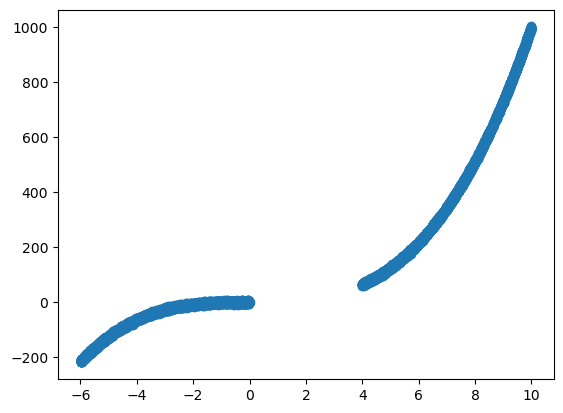

In [2]:
n = 10000
X = np.random.default_rng().uniform(-6, 10, size=n)
X = X[(X < 0) | (X>4)]

std = 3.0
noise = np.random.default_rng().normal(loc=0.0, scale=std, size=X.shape[0])

y = X ** 3 + noise
plt.scatter(X,y)

In [3]:
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

import tensorflow as tf
from evml.keras.callbacks import get_callbacks, ReportEpoch
from evml.keras.models import EvidentialRegressorDNN

2023-07-12 16:22:06.126618: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 16:22:06.189033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 16:22:08.734572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = np.concatenate((X_test, np.arange(0,4,0.05)))
noise = np.random.default_rng().normal(loc=0.0, scale=std, size=X_test.shape[-1])
y_test = X_test ** 3 + noise

X_train, X_test = X_train.reshape(-1,1), X_test.reshape(-1,1)
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)


input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

y_train_scaled = output_scaler.fit_transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

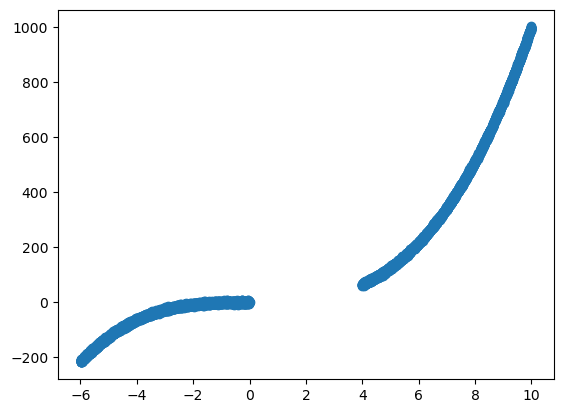

In [5]:
plt.scatter(X_train, y_train)

2/2 [==============================] - 0s 4ms/step


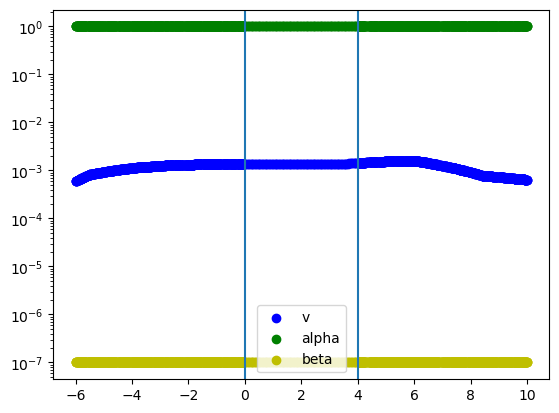

2/2 [==============================] - 0s 14ms/step


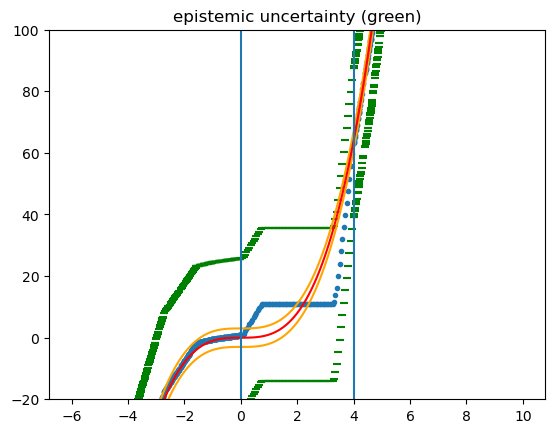

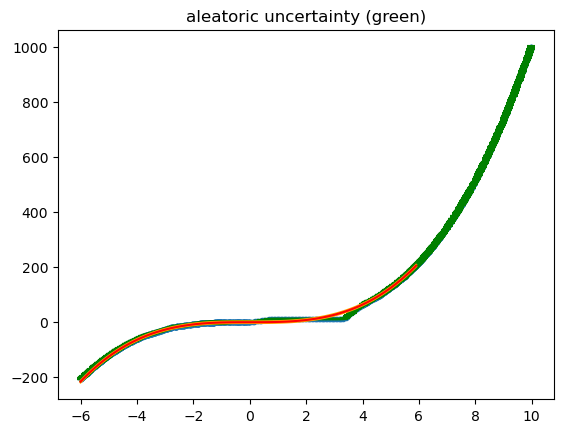

In [7]:
np.random.seed(986)
coupling = 2.0
mlp = EvidentialRegressorDNN(hidden_layers=3,
                            hidden_neurons=50,
                            activation='relu',
                            loss='evidentialReg',
                            coupling_coef=coupling,
                            evidential_coef=1000,
                            epochs = 5000,
                            batch_size = 1000,
                            optimizer='adam',
                            lr=5e-3,
                            l2_weight=0.01,
                            l1_weight=0.01,
                            eps=1e-7,
                            eps_v=1e-7)
mlp.build_neural_network(1,1)
history = mlp.fit(X_train_scaled, y_train_scaled, use_multiprocessing=True)
#plt.plot(history.history['loss'])
mu, v, alpha, beta = mlp.predict_dist_params(X_test_scaled, output_scaler)
plt.scatter(X_test, v, color='b').set_label("v")
plt.scatter(X_test, alpha, color='g').set_label("alpha")
plt.scatter(X_test, beta, color='y').set_label("beta")
plt.legend()
plt.yscale('log')
plt.axvline(4)
plt.axvline(0)
plt.show()
mu, al, epis = mlp.predict(X_test_scaled, scaler=output_scaler, batch_size=None)

al = np.sqrt(al)
epis = np.sqrt(epis)

ax = plt.gca()

ax.scatter(X_test, mu, marker='.')
ax.scatter(X_test, mu + epis,c = 'g', marker='_')
ax.scatter(X_test, mu - epis,c ='g', marker='_')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 + 3, color='orange')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 - 3, color='orange')


plt.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3, color='r')
ax.axvline(0)
ax.axvline(4)
_ = ax.set_title('epistemic uncertainty (green)')
ax.set_ylim(-20,100)
plt.show()

ax = plt.gca()

ax.scatter(X_test, mu, marker='.')
ax.scatter(X_test, mu + al,c = 'g', marker='_')
ax.scatter(X_test, mu - al,c ='g', marker='_')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 + 3, color='orange')
ax.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3 - 3, color='orange')


plt.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3, color='r')
_ = ax.set_title('aleatoric uncertainty (green)')

mu, v, alpha, beta = mlp.predict_dist_params(X_test_scaled, output_scaler)
plt.scatter(X_test, mu)

plt.plot(np.arange(-6,6,0.1), np.arange(-6,6,0.1) ** 3, color='r')